## Curve fitting 

This script is going to be used by me to play about with the different settings of the Scipy.optimize tool kit to see if I can work out how to include bounds on a curve fitting. What the limits of the curve fitting are. And if there is a significant difference in the suitability of the different CF algorithms for our purposes. 

The aim of this is to get a better handle on th curve fitting algorithms and how to implement a method of fitting a square wave function to our data as will be needed for lock-in amplification. 

In [1]:
import numpy as np 
import scipy.optimize as opt 
import matplotlib.pyplot as plot 
import scipy.signal as sig

In [2]:
plot.rcParams.update({'font.size' : 20})
plot.rcParams.update({'figure.figsize' :[12, 8]})

### Script Note

I will start the optimisation routine just trying to fit a linear curve to a linear data set with a random nise distribution. 

In [115]:
def linear_function(x, M, C):
    # M = gradient and C = intercept
    y = M*x + C
    return(y)

In [34]:
def randomiser(y, A):
    # add a random noise to a function. 
    y_noise = y + np.random.randn(len(y))*A
    return(y_noise)

In [124]:
def opt_linear(x, y):
    
    P0 = [3.2, 25]
    
    low_bound = [3, -np.inf]
    upper_bound = [4, np.inf]
    
    opt_fit, confidence = opt.curve_fit(linear_function, x, y, P0, bounds = (low_bound, upper_bound))
    print(opt_fit)
    
    y_fit = linear_function(x, opt_fit[0], opt_fit[1])
    
    return(y_fit)

In [125]:
x = np.linspace(0,10,100)
y = linear_function(x, 5, 10)

y_noise = randomiser(y)

[ 4.         14.89711474]


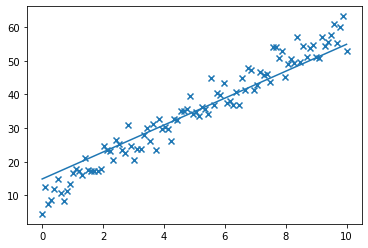

In [126]:
#plot.plot(x, y)
plot.scatter(x, y_noise, marker = 'x')
y_fit = opt_linear(x, y_noise)
plot.plot(x, y_fit)

### Script Note: What I learned. 

The most important thing I learned with this portion of the coding exploration is that (unsurprisingly) the initial guess must be within the bounds that you are appling to the curve fitting algorithm. If you don't do this, then you get the following sort of error: 

"" X0 is infeasable "" 

### Script note: 

I will now try to fit a double lorentzian line shape to some OMDR data with the bounds being used to constrict the area overwhich the optimisation routine can be performed. 

In [9]:
def load_data(file_path): 
    # load the ODMR data file in to an np array 
    data_array = np.loadtxt(file_path)
    return(data_array)

In [138]:
def mean_data(odmr_data):
    # find the mean data 
    mean_odmr_data =  np.mean(odmr_data, axis=0)
    return(mean_odmr_data)

In [139]:
def scatter_plot(freq,mean_data):
    # Creates a scatter plot for experimental data and plot parameters. 
    fig2, ax2 = plot.subplots()
    plot.rcParams.update({'font.size' : 16})
    plot.rcParams.update({'figure.figsize' :[12, 8]})
    ax2.scatter(freq, mean_data, marker = 'x',color = 'r', label = "ODMR Data")
    ax2.set_xlim(np.min(freq),np.max(freq))
    return(fig2, ax2)

In [165]:
def optimised_lorentz_fit(freq, mean_data, init_params, lower_bound, upper_bound):
    # A method to find the fitting prameters for the ODMR dataset. 
    y_error = np.sqrt(mean_data) # poissonian noise
    coeffs, confidence = opt.curve_fit(double_lorentz, freq, mean_data, init_params, 
                                       sigma = y_error, bounds = (lower_bound, upper_bound))
    opt_error = np.sqrt(np.diag(confidence))
    
    return(coeffs, opt_error)

In [162]:
def double_lorentz(x, A1, X01, sig1, A2, X02, sig2, offset): #P0[0], P0[1], P0[2], P0[3], P0[4], P0[5], P0[6]):
    # A1 = Amplitude 1, X01 = Resonance 1, sig1 = FWHM 1
    # A2 = Amplitude 2, X02 = Resonance 2, sig2 = FWHM 2, offset = offset
    
    first_peak = (-A1/np.pi)*((sig1**2)/(sig1**2 +(2*x-2*X01)**2))
    second_peak = (-A2/np.pi)*((sig2**2)/(sig2**2 +(2*x-2*X02)**2))
    
    return (first_peak + second_peak + offset)

In [163]:
def plot_fitting(ax2, freq, y_fit):
    # plot the y fit. 
    
    ax2.plot(freq, y_fit, color='k', label='Double Lorentz \nfitting')
    ax2.legend()
    ax2.set_xlabel('Microwave Frequency (GHz)', fontsize = 18)
    ax2.set_ylabel('Normalised Counts', fontsize = 18)
    
    return(ax2)

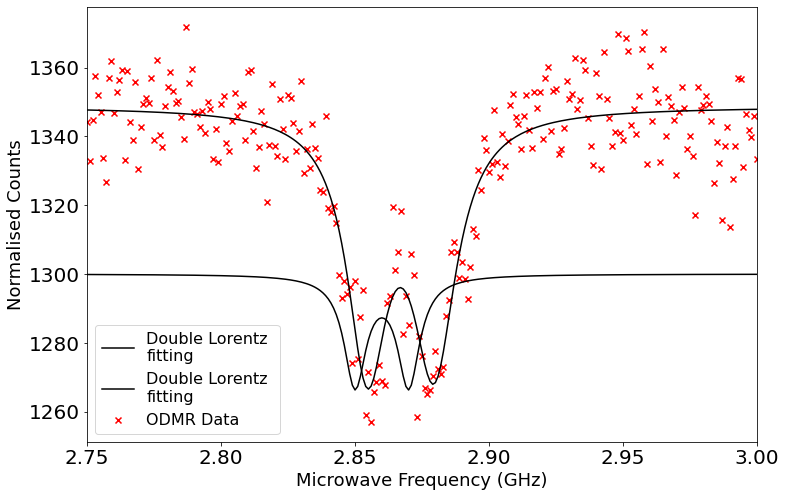

In [172]:
folder_path = 'I:\\Science\\Physics-Nanobiophotonics\\Group\\User Data\\ODMR\\ODMR and imaging\\'
date = '20201127'
file_name = date + '_NVScan_69'

plot.rcParams.update({'font.size' : 20})
plot.rcParams.update({'figure.figsize' :[12, 8]})

odmr = load_data(folder_path + date + '\\' + file_name + '.dat')
mean_odmr = np.mean(odmr, axis=0)

freq = np.linspace(2.75, 3.00, 251)

fig, ax = scatter_plot(freq, mean_odmr)

init_params = [100, 2.85, 0.01, 100, 2.87, 0.01, 1300]

lower_bounds = [-np.inf, init_params[1]-0.01, 0, -np.inf, init_params[4]-0.01, 0, 0]
upper_bounds = [np.inf, init_params[1] + 0.01, 1, np.inf, init_params[4] + 0.01, 1, np.inf]

# Amp 1, Res freq 1, FWHM 1, Amp 2, Res freq 2, FWHM 2, Amp.

y_init = double_lorentz(freq, init_params[0], init_params[1], init_params[2], 
                      init_params[3], init_params[4], init_params[5], init_params[6])

ax =  plot_fitting(ax, freq, y_init)

opt_fit, confidence = optimised_lorentz_fit(freq, mean_odmr, init_params, lower_bounds, upper_bounds)
y_fit = double_lorentz(freq, opt_fit[0], opt_fit[1], opt_fit[2], 
                       opt_fit[3], opt_fit[4], opt_fit[5], opt_fit[6])

ax =  plot_fitting(ax, freq, y_fit)


### Script Note: 

So this has been a cool little experience, looks like every time I have tried to do this up until now, I have managed to make a pigs ear of setting the boundries up in such a way that the upper and lower bounds have always encapsulated the initial parameter. I have taken the lessons from this code and added it into the main ODMR evaluation script and tinkered with a couple of things. I think this will make it a much better and more rounded script from here on in :)

### Script note: 

So now that I have a better idea of how this curve fitting toolbox works with respect to setting boundries. I will now attempt to make a function that generates a noisy square wave, and then will try to fit a square wave to the data. 

I will start off with very little noise and a large amplitude signal to make the process of curve fitting as simple as possible. From there, I will then increase the noise and reduce signal amplitude to better approximate the square wave function. 

In [3]:
def create_square_wave(x, A, B, C, D, phi):
    # generate a sqaure wave 
    # A = amplitude, B = frequency, C = Y offset.
    y = A*sig.square(2*np.pi*B*x + phi, duty = D) + C
    return(y)

In [31]:
def optimise_square(t, y, freq, duty):
    
    #p0 = [0.5*(np.max(y) - np.min(y)), freq, np.mean(y), duty, 0]
    p0 = [ 7, freq, 17.5, duty, np.pi/4]
    
    print('Amplitude = ' + str(p0[0]) + '\n' +
          'Frequency = ' + str(p0[1]) + '\n' +
          'Offset = ' + str(p0[2]) + '\n' +
          'Duty Cycle = ' + str(p0[3]) + '\n' + 
          'Phase constant = ' + str(p0[4]) )
    
    lower_bound = [p0[0]*0.5, freq*0.9, 0, duty-0.1, 0]
    upper_bound = [p0[0]*1.5, freq*1.1, np.max(y), duty+0.1, 2*np.pi]
    
    opt_params, confidence = opt.curve_fit(create_square_wave, t, y, 
                                          p0, bounds = (lower_bound, upper_bound))
    
    y_fit = create_square_wave(t, opt_params[0], opt_params[1], opt_params[2], 
                              opt_params[3], opt_params[4])
    
    print('Amplitude = ' + str(opt_params[0]) + '\n' +
          'Frequency = ' + str(opt_params[1]) + '\n' +
          'Offset = ' + str(opt_params[2]) + '\n' +
          'Duty Cycle = ' + str(opt_params[3]) + '\n' + 
          'Phase constant = ' + str(opt_params[4]) )
          
    return(y_fit)

Here we have the code for a computer generated square wave.

Amplitude = 7
Frequency = 1
Offset = 17.5
Duty Cycle = 0.5
Phase constant = 0.7853981633974483
Amplitude = 5.00000420730697
Frequency = 1.0
Offset = 10.000000189769693
Duty Cycle = 0.5
Phase constant = 0.7853981633974483


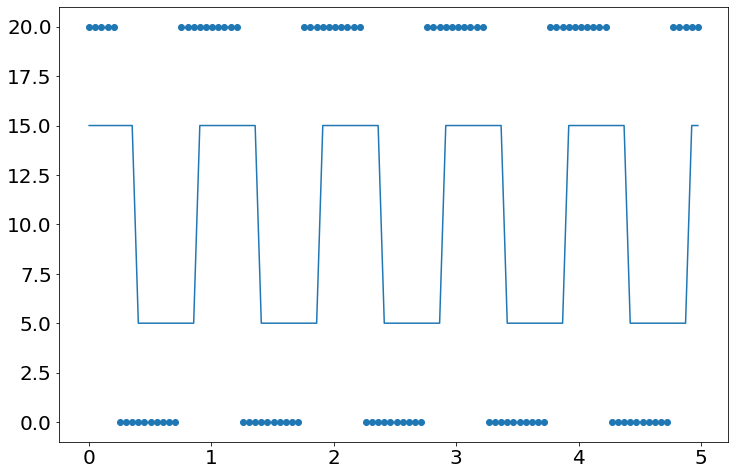

In [32]:
freq = 1
duty_cycle = 0.5

t = np.linspace(0, 10, 200)
y_square = create_square_wave(t, 10, freq, 10, duty_cycle, np.pi/2)
y_square_noise = y_square#randomiser(y_square, 1)
plot.scatter(t[0:100], y_square_noise[0:100])

y_fit = optimise_square(t, y_square_noise, freq, duty_cycle)

plot.plot(t[0:100], y_fit[0:100])


Here we load in data from a square wave signal generated by recording the fluorescence intensity from a nanodiamond while the AOM is used to pulse the excitation laser using a square wave signal. 

In [10]:
# load in square wave data

data = load_data('I:\\Science\\Physics-Nanobiophotonics\\Group\\User Data\\ODMR\\ODMR and imaging\\20201211\\20201211_NVScan_03.dat')
square_wave = data[0,0:100]

(100,)
(100,)
Amplitude = 49.5
Frequency = 1000
Offset = 76.01
Duty Cycle = 0.5
Phase constant = 0
Amplitude = 24.750000009495526
Frequency = 1000.0
Offset = 75.51496392889959
Duty Cycle = 0.5
Phase constant = 1e-10


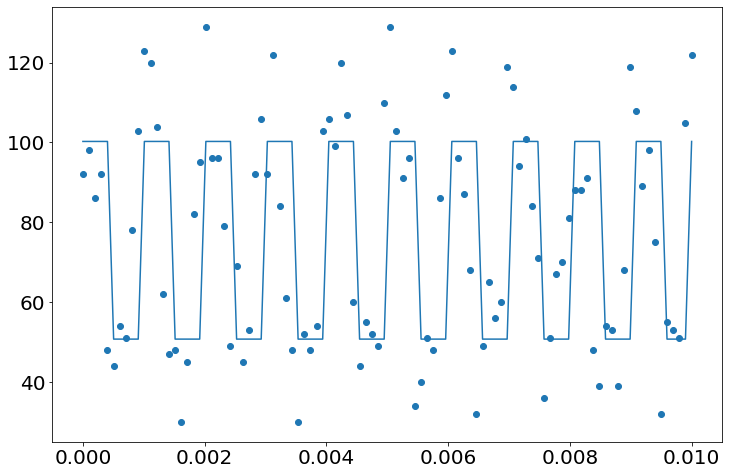

In [11]:
points = len(square_wave)
dwelltime = 10**-4 #s

sample_frequnecy = 10000

duty = 0.5

time = np.linspace(0, points*dwelltime, points)
freq = 1000 # hertz 
print(time.shape)
print(square_wave.shape)
plot.scatter(time, square_wave)

y_fit = optimise_square(time, square_wave, freq, duty)

plot.plot(time, y_fit)

### Script note: 

Okay, so I have learned a lot trying to get this script to work. 

1. The optimisation prgram is absolutely awful at optimising the frequnecy of a signal. So to get around this, I have fixed the frequnecy and bound it tightly. This is because in lock-in amplification, we would know what the frequnecy of modulation is going to be. 
2. You have to be careful with the range that you allow for the amplitude of the oscillations, because very quickly the program can decide it is easier to lower the amplitude of the square wave amplitue and just have a consistant error across the whole signal. (it effectively gives up trying to actually fit the data. 
3. The offset is actually a pretty fit, but its an easier variable to estimate in the beginning. 
4. Duty cycle needs to be fairly well fixed. 
5. The bloody phase constant, the most important variable is a nightmare to fix. 

### Script note:

I will attempt to find an approximation for the phase constant from the computer generated square wave. 

The idea behind this code is to work out the ratio of points which exist in the "on state" before the off state occurs, OR visa versa. The code then works to determine the phase constant for the code, which should be proportional to the ratio of data points that exist before the amplitude of the square wave changes. 

[10, 1, 10, 0.5, 0.7853981633974483]
Amplitude = 10
Frequency = 1
Offset = 10
Duty Cycle = 0.5
Phase constant = 0.7853981633974483
Amplitude = 5.0000000005140235
Frequency = 1.0
Offset = 10.004646689989684
Duty Cycle = 0.5
Phase constant = 0.7853981633974483


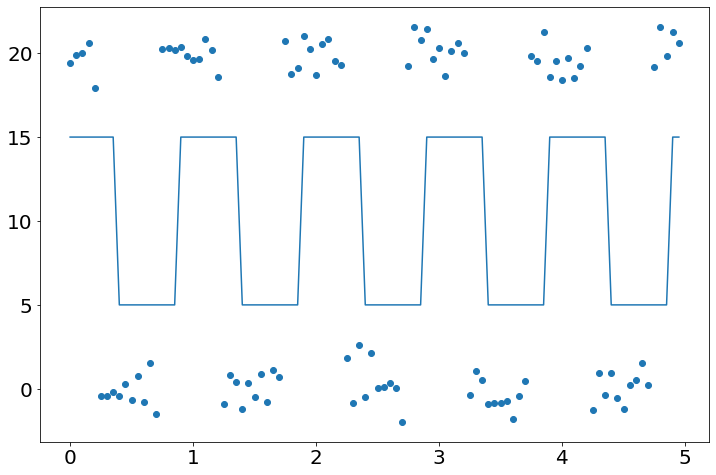

In [61]:
freq = 1
duty_cycle = 0.5

t = np.linspace(0, 100, 2000)

init_values = [10, freq, 10, duty_cycle, np.pi/4]

y_square = create_square_wave(t, 10, freq, 10, duty_cycle, np.pi/2)
y_square_noise = randomiser(y_square, 1)
plot.scatter(t[0:100], y_square_noise[0:100])

y_fit = optimise_square_2(t, y_square_noise, init_values)

plot.plot(t[0:100], y_fit[0:100])

[10, 1, 10, 0.5, 1.9707963267948965]
[ 0  1  2  3  4 15 16 17 18 19]
[10, 1, 10, 0.5, 1.5707963267948966]
Amplitude = 10
Frequency = 1
Offset = 10
Duty Cycle = 0.5
Phase constant = 1.5707963267948966
Amplitude = 10.013474779913361
Frequency = 1.0
Offset = 10.004653629517174
Duty Cycle = 0.5
Phase constant = 1.5707963267948966


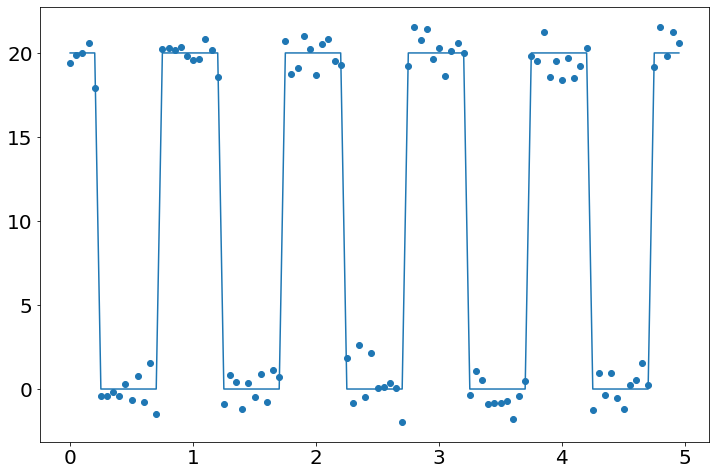

In [63]:
sample_freq = len(t)/np.max(t)
print(init_values)

phi = find_phase_constant(y_square_noise, sample_freq, freq)
init_values[4] = phi

y_fit_2 = optimise_square_2(t, y_square_noise, init_values)



plot.scatter(t[0:100], y_square_noise[0:100]) # plot noisy square
plot.plot(t[0:100], y_fit_2[0:100]) # plot fitting with "calculated phase"

In [37]:
def find_phase_constant(y, sample_frequnecy, freq):
    
    points = int(sample_frequnecy/freq)
    mean_counts = np.mean(y)
    ratio = []
    
    for i in range(points):
        if y[i] > mean_counts:
            ratio.append(1)
        else:
            ratio.append(0)
    ratio = np.array(ratio)
    find_indicies = np.where(ratio==1)[0]
    print(find_indicies)
    
    index = []
    
    for i in range(len(find_indicies)-1):
        if find_indicies[i]+1 != find_indicies[i+1]:
            index.append(i+1)
    
    if index == []:
        index.append(find_indicies[0])
            
   
    phase_constant_guess = (index[0]*(2*np.pi))/points
    
    return(phase_constant_guess)

### Script note:

The code is working currently. I will now try it for the dataset from the microscope. I will do this however in a new script because this one is getting a littl cluttered. 

In [48]:
def optimise_square_2(t, y, init_values):
    
    #p0 = [0.5*(np.max(y) - np.min(y)), freq, np.mean(y), duty, 0]
    p0 = [init_values][0]
    print(p0)
    
    print('Amplitude = ' + str(p0[0]) + '\n' +
          'Frequency = ' + str(p0[1]) + '\n' +
          'Offset = ' + str(p0[2]) + '\n' +
          'Duty Cycle = ' + str(p0[3]) + '\n' + 
          'Phase constant = ' + str(p0[4]) )
    
    lower_bound = [p0[0]*0.5, freq*0.9, 0, duty-0.1, 0]
    upper_bound = [p0[0]*1.5, freq*1.1, np.max(y), duty+0.1, 2*np.pi]
    
    opt_params, confidence = opt.curve_fit(create_square_wave, t, y, 
                                          p0, bounds = (lower_bound, upper_bound))
    
    y_fit = create_square_wave(t, opt_params[0], opt_params[1], opt_params[2], 
                              opt_params[3], opt_params[4])
    
    print('Amplitude = ' + str(opt_params[0]) + '\n' +
          'Frequency = ' + str(opt_params[1]) + '\n' +
          'Offset = ' + str(opt_params[2]) + '\n' +
          'Duty Cycle = ' + str(opt_params[3]) + '\n' + 
          'Phase constant = ' + str(opt_params[4]) )
          
    return(y_fit)